# Генетические алгоритмы для определения оптимального маршрута погрузки контейнера на поезд

In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

Файл формата geoJSON содержит данные по точкам где могут быть контейнеры под погрузку и поезд. Для получения файла использовался сервис https://geojson.io/ 

In [2]:
zone = gpd.read_file('./data/containers_zone.json')
zone.head(5)

,marker-color,num,geometry
0,#e81717,1,POINT (30.35992 59.96832)
1,#05f521,1,POINT (30.36156 59.96800)
2,#e81717,2,POINT (30.36001 59.96828)
3,#05f521,2,POINT (30.36220 59.96771)
4,#e81717,3,POINT (30.36011 59.96824)


Визуализация данных из файла. Начальное положение ричстакера выбрано произвольно в географической точке Point(30.36090810069993, 59.9681123344929)

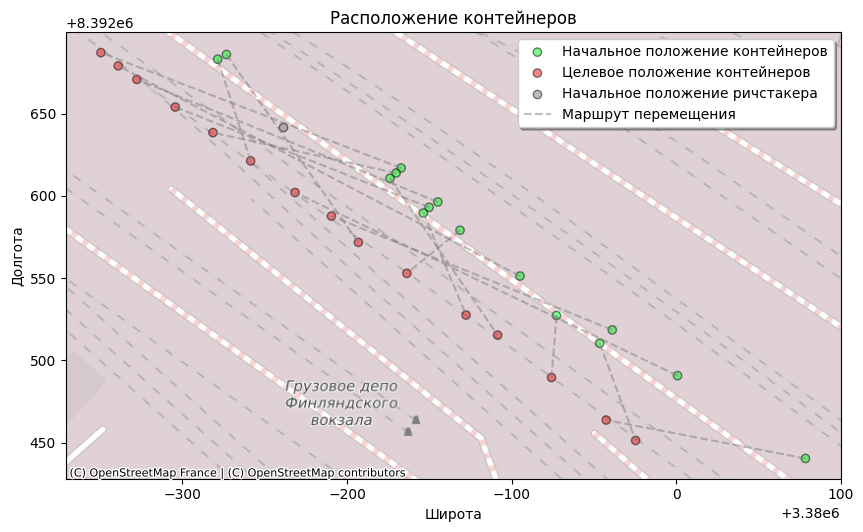

In [105]:
mask = zone['marker-color'] == '#05f521'
initial, target = zone[mask], zone[~mask]

fig, ax = plt.subplots(figsize=(10, 10))

ax.set(title = 'Расположение контейнеров', xlabel = 'Широта', ylabel = 'Долгота')

initial.to_crs(epsg=3857).plot(
    ax=ax,
    figure=fig, 
    alpha=0.5, 
    color=initial['marker-color'],
    edgecolor='k',
    label='Начальное положение контейнеров'
)
target.to_crs(epsg=3857).plot(
    ax=ax,
    figure=fig, 
    alpha=0.5, 
    color=target['marker-color'],
    edgecolor='k', 
    label='Целевое положение контейнеров'
)

d = {
    'marker-color': ['#7e7e7e'], 
    'num': [0], 
    'geometry': [Point(30.36090810069993, 59.9681123344929)]
}

richstacker = gpd.GeoDataFrame(d, crs="EPSG:4326")
richstacker.to_crs(epsg=3857).plot(
    ax=ax,
    figure=fig, 
    alpha=0.5, 
    color=richstacker['marker-color'],
    edgecolor='k',
    label='Начальное положение ричстакера'
)


route = initial.merge(
    target, 
    how='inner', 
    on='num', 
    left_on=None, 
    right_on=None, 
    left_index=False, 
    right_index=False, 
    sort=False, 
    suffixes=('_initial', '_target'), 
    copy=True, 
    indicator=False, 
    validate=None,
)

route['geometry'] = route.apply(
    lambda row: LineString(
        [row['geometry_initial'], row['geometry_target']]
    ), 
    axis=1
)
route = gpd.GeoDataFrame(route, crs="EPSG:4326", geometry=route['geometry'])
route.to_crs(epsg=3857).plot(
    ax=ax,
    figure=fig,
    alpha=0.5, 
    label='Маршрут перемещения',
    linestyle='--',
    color='#7e7e7e', 
)

ctx.add_basemap(
    ax=ax, 
    zoom=18, 
    source=ctx.providers.OpenStreetMap.France
)


ax.legend(shadow = True)

In [296]:
import random
import matplotlib.pyplot as plt
 
# константы задачи
ONE_MAX_LENGTH = 15    # длина подлежащей оптимизации битовой строки
 
# константы генетического алгоритма
POPULATION_SIZE = 40    # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.1        # вероятность мутации индивидуума
INDPB = 0.01             # степень мутации индивидуума
MAX_GENERATIONS = 10    # максимальное количество поколений

In [297]:
class FitnessMax():
    def __init__(self):
        self.value = 0
 
 
class Individual(list):
    def __init__(self, *args):
        super().__init__(*args)
        self.fitness = FitnessMax()

In [298]:
def oneMaxFitness(individual=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):
    
    current_position = richstacker.geometry.values
    current_position = current_position.to_crs(crs=3857)
    
    distance = []
    
    for container_num in individual:       
        row = route[route['num'] == container_num]
        initial_container_position = row.geometry_initial.values
        initial_container_position = initial_container_position.to_crs(crs=3857)
        target_container_position = row.geometry_target.values
        target_container_position = target_container_position.to_crs(crs=3857)
        
        distance.append(current_position.distance(initial_container_position)[0])
        current_position = initial_container_position
        distance.append(current_position.distance(target_container_position)[0])
        current_position = target_container_position
        
    return int(sum(distance))

In [299]:
def individualCreator():
    return Individual(random.sample(range(1, ONE_MAX_LENGTH + 1), ONE_MAX_LENGTH))
 
def populationCreator(n = 0):
    return list([individualCreator() for i in range(n)])

In [300]:
population = populationCreator(n=POPULATION_SIZE)

In [301]:
fitnessValues = [oneMaxFitness(individual) for individual in population]

[4298, 4203, 4516]

In [302]:
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.value = fitnessValue

In [303]:
def clone(value):
    """Функция клонирования индивидуальной хромосомы."""
    ind = Individual(value[:])
    ind.fitness.value = value.fitness.value
    return ind

In [308]:
def selTournament(population):
    """Функция проведения турнира (отбора индивидуумов)."""
    offspring = []
    p_len = len(population)
    for n in range(p_len):
        i1 = i2 = i3 = 0
        while i1 == i2 or i1 == i3 or i2 == i3:
            i1, i2, i3 = random.randint(0, p_len-1), random.randint(0, p_len-1), random.randint(0, p_len-1)
        offspring.append(
            min([population[i1], population[i2], population[i3]], 
                key=lambda ind: ind.fitness.value)
        )
 
    return offspring

In [305]:
def cxOrdered(ind1, ind2):
    """Алгоритм упорядоченного скрещивания."""

    def fulfill_from_ind(indexes, ind, child):
        for idx in indexes:
            for k in range(size):
                if ind[k] not in child:
                    child[idx] = ind[k]
        return child
    
    size = min(len(ind1), len(ind2))
    a, b = random.sample(range(size), 2)
    
    if a > b: a, b = b, a
    
    child1_partly_fullfilled = [ind2[i] if (a <= i <= b) else None for i in range(size)]
    child2_partly_fullfilled = [ind1[i] if (a <= i <= b) else None for i in range(size)]
    
    indexes = [item for item in range(b, size)] + [item for item in range(a)]
    child1 = Individual(fulfill_from_ind(indexes, ind1, child1_partly_fullfilled))
    child2 = Individual(fulfill_from_ind(indexes, ind2, child2_partly_fullfilled))
    
    return child1, child2

In [306]:
def mutShuffleIndexes(individual, indpb):
    """Алгоритм мутации.
    indpb: float - степень мутации
    """
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx += 1
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]

    return individual

Поколение 1: Лучшее расстояние = 3551, Среднее расстояние = 3964.675
Лучший порядок погрузки контейнеров =  2 12 10 8 11 15 14 13 7 1 4 9 5 3 6 

Поколение 2: Лучшее расстояние = 3579, Среднее расстояние = 3912.375
Лучший порядок погрузки контейнеров =  6 8 12 10 11 15 14 13 7 1 4 9 2 5 3 

Поколение 3: Лучшее расстояние = 3453, Среднее расстояние = 3955.15
Лучший порядок погрузки контейнеров =  11 10 8 12 2 15 14 13 7 4 9 5 3 6 1 

Поколение 4: Лучшее расстояние = 3469, Среднее расстояние = 3939.65
Лучший порядок погрузки контейнеров =  11 2 8 12 10 15 14 13 7 4 9 5 3 6 1 

Поколение 5: Лучшее расстояние = 3453, Среднее расстояние = 3934.225
Лучший порядок погрузки контейнеров =  11 10 8 12 2 15 14 13 7 4 9 5 3 6 1 

Поколение 6: Лучшее расстояние = 3346, Среднее расстояние = 3766.2
Лучший порядок погрузки контейнеров =  12 8 11 2 10 15 14 13 7 4 9 5 3 6 1 

Поколение 7: Лучшее расстояние = 3346, Среднее расстояние = 3818.5
Лучший порядок погрузки контейнеров =  12 8 11 2 10 15 14 13 

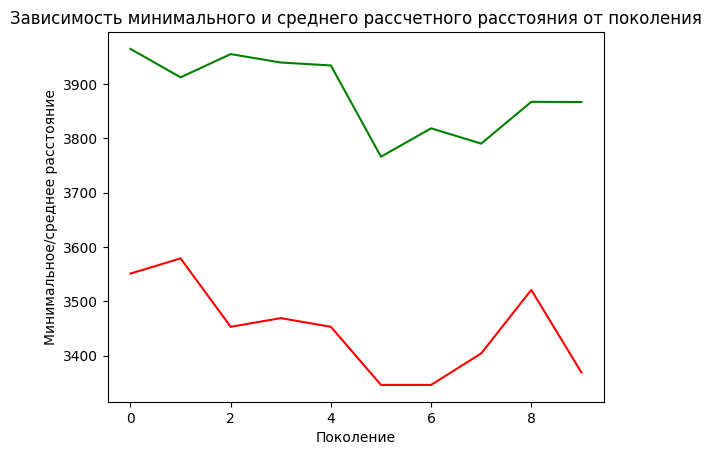

Лучший способ погрузки [12, 8, 11, 2, 10, 15, 14, 13, 7, 4, 9, 5, 3, 6, 1]. Совокупное расстояние 3346 метров


In [310]:
generationCounter = 0
maxFitnessValues = []
meanFitnessValues = []
hall_of_fame = {}

while generationCounter < MAX_GENERATIONS:
    generationCounter += 1
    
    offspring = selTournament(population)

    next_generation_offspring = []
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            child1, child2 =  cxOrdered(ind1, ind2)
        else:
            child1, child2 = ind1, ind2
        next_generation_offspring.append(child1)
        next_generation_offspring.append(child2)
    offspring = next_generation_offspring
    
    offspring_mutated = []
    for individual in offspring:
        if random.random() < P_MUTATION:
            mutant = mutShuffleIndexes(individual, indpb=INDPB)
            offspring_mutated.append(mutant)
        else:
            offspring_mutated.append(individual)
    offspring = offspring_mutated
    
    
    freshFitnessValues = [oneMaxFitness(individual) for individual in offspring]
    
    for individual, fitnessValue in zip(offspring, freshFitnessValues):
        individual.fitness.value = fitnessValue
        
    population[:] = offspring
    fitnessValues = [ind.fitness.value for ind in population]
    
    maxFitness = min(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    
    print(f"Поколение {generationCounter}: Лучшее расстояние = {maxFitness}, Среднее расстояние = {meanFitness}")
    best_index = fitnessValues.index(min(fitnessValues))
    print("Лучший порядок погрузки контейнеров = ", *population[best_index], "\n")
    
    hall_of_fame[min(fitnessValues)] = population[best_index]
    
    
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Минимальное/среднее расстояние')
plt.title('Зависимость минимального и среднего рассчетного расстояния от поколения')
plt.show()

best_distance = min(hall_of_fame.keys())
best_individual = hall_of_fame[best_distance]

print(f'Лучший способ погрузки {best_individual}. Совокупное расстояние {best_distance} метров')
